# Projeto Jogador de Forca

## Importações

Importa bibliotecas como random, matplotlib, numpy, scipy, e requests, essenciais para funcionalidades de geração de números aleatórios, visualização de dados, cálculo de estatísticas, e obtenção de dados externos.

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import requests

## Funções importantes

Implementa uma árvore de Huffman para compressão, calculando a frequência de cada caractere no texto para otimizar o armazenamento. Pode ser usada para codificar e decodificar palavras.

In [3]:
def huffman_tree(texto : str):
    """Monta a arvore de codificacao usando o algoritmo de huffman"""
    def get_prob(item):
        return item['prob']

    f = []

    # Calcula probabilidade de cada caractere      
    for c in set(texto):
        f.append(  {'prob':texto.count(c)/len(texto), 'valor':c} )
    f.sort(key=get_prob)
    
    while len(f) > 1:
        c1 = f.pop(0)
        c2 = f.pop(0)
        novo_node = {'valor':'NAO_FOLHA', 'prob':c1['prob']+c2['prob'], 'filho_0':c1, 'filho_1': c2}
        
        f.insert(0, novo_node)
        f.sort(key=get_prob)

    return f[0]

## Classe JogoDeForca

Define a estrutura principal do jogo, contendo os métodos para inicializar e jogar.

Implementa o jogo de forca, incluindo métodos para iniciar um novo jogo, verificar letras, e fazer tentativas de adivinhar a palavra, controlando as vidas restantes do jogador.

In [4]:
class JogoDeForca:
    def __init__(self):
        url = 'https://www.ime.usp.br/~pf/dicios/br-sem-acentos.txt'
        r = requests.get(url, allow_redirects=True)
        if r.status_code==200:
            self.content = str(r.content.decode()).split('\n')
        else:
            print("Erro: ", r.status_code)
    
    def novo_jogo(self, vidas=5):
        self.vidas = vidas
        self.palavra = random.choice(self.content)
        return len(self.palavra)

    def tentar_letra(self, letra):
        if self.vidas > 0:
            if letra in self.palavra:
                return [idx for idx in range(len(self.palavra)) if self.palavra[idx]==letra]
            else:
                self.vidas -= 1
                if self.vidas == 0:
                    print("Fim de jogo!")
                    return False
                else:
                    return []
        
    def tentar_palavra(self, palavra):
        if self.vidas > 0:
            if self.palavra == palavra:
                print ("Ganhou!")
                return True
            else:
                self.vidas = 0
                print("Fim de jogo!")
                return False

## Testes do Funcionamento do Jogo

 Introduz os testes que verificam se o jogo de forca está funcionando como esperado.


 Testa o funcionamento da classe JogoDeForca ao iniciar um jogo, exibir a palavra e o número de vidas, e fazer tentativas de adivinhar letras.

In [5]:
jogo = JogoDeForca()
print(jogo.novo_jogo())
print(jogo.palavra)
print(jogo.vidas)
print(jogo.tentar_letra('b'))
print(jogo.tentar_letra('a'))
print(jogo.tentar_letra('w'))
print(jogo.vidas)

11
predefinida
5
[]
[10]
[]
3


## Jogador

Define a classe para um jogador que interage com o jogo.


Implementa um jogador que utiliza estratégias para adivinhar palavras no jogo de forca. Contém métodos para filtrar palavras, contar a frequência das letras, jogar, e exibir o desempenho com gráficos.

In [6]:
class Jogador:
    def __init__(self, jogo):
        self.jogo = jogo
        self.vitorias = 0
        self.derrotas = 0
    
    
    def filtrar_palavras(self, tamanho, letras_acertadas, letras_erradas):
        """Filtra palavras candidatas com base no tamanho e no padrão atual de acertos e erros."""
        palavras_possiveis = [palavra for palavra in self.jogo.content if len(palavra) == tamanho]

        for i, letra in enumerate(letras_acertadas):
            if letra != '_':
                palavras_possiveis = [p for p in palavras_possiveis if p[i] == letra]
        
        palavras_possiveis = [p for p in palavras_possiveis if all(letra not in p for letra in letras_erradas)]
        
        return palavras_possiveis
    

    def contar_frequencia_letras(self, palavras, letras_excluidas):
        """Conta a frequência das letras nas palavras candidatas, excluindo letras já tentadas."""
        frequencias = {}
        for palavra in palavras:
            for letra in palavra:
                if letra not in letras_excluidas:
                    frequencias[letra] = frequencias.get(letra, 0) + 1
        
        return sorted(frequencias, key=frequencias.get, reverse=True)
    

    def jogar(self, tentativas=100):
        for _ in range(tentativas):
            tamanho_palavra = self.jogo.novo_jogo()
            letras_acertadas = ['_'] * tamanho_palavra
            letras_tentadas = set()
            letras_erradas = set()
            venceu = False
            
            while self.jogo.vidas > 0:
                palavras_candidatas = self.filtrar_palavras(tamanho_palavra, letras_acertadas, letras_erradas)

                letras_frequentes = self.contar_frequencia_letras(palavras_candidatas, letras_tentadas)
                
                if not letras_frequentes:
                    break
                
                letra = letras_frequentes[0]
                letras_tentadas.add(letra)
                
                resultado = self.jogo.tentar_letra(letra)
                
                if resultado:
                    for idx in resultado:
                        letras_acertadas[idx] = letra
                    if "_" not in letras_acertadas:
                        venceu = True
                        break
                else:
                    letras_erradas.add(letra)
            
            if venceu:
                self.vitorias += 1
            else:
                self.derrotas += 1
    

    def mostrar_resultados(self):
        fig, ax = plt.subplots(figsize=(8, 6))
        
        resultados = ['Vitórias', 'Derrotas']
        valores = [self.vitorias, self.derrotas]
        cores = ['green', 'red']
        
        barras = ax.bar(resultados, valores, color=cores, edgecolor='black')
        
        for barra in barras:
            altura = barra.get_height()
            ax.annotate(f'{int(altura)}',
                        xy=(barra.get_x() + barra.get_width() / 2, altura),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        ax.set_xlabel('Resultado', fontsize=14, fontweight='bold')
        ax.set_ylabel('Quantidade', fontsize=14, fontweight='bold')
        ax.set_title('Desempenho do Jogador no Jogo de Forca', fontsize=16, fontweight='bold')
        
        plt.show()

## Resultados

Define a célula que exibe os resultados finais do jogo após várias tentativas.


Cria uma instância do jogo e do jogador, inicia o jogo com várias rodadas, e exibe os resultados finais em um gráfico de barras, visualizando as vitórias e derrotas.

Fim de jogo!
Fim de jogo!
Fim de jogo!
Fim de jogo!
Fim de jogo!
Fim de jogo!
Fim de jogo!
Fim de jogo!
Fim de jogo!
Fim de jogo!
Fim de jogo!
Fim de jogo!


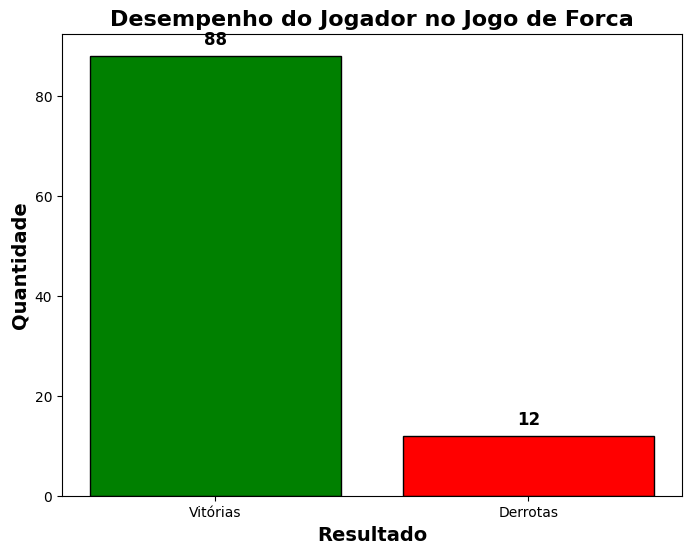

In [8]:
jogo = JogoDeForca()
jogador = Jogador(jogo)
jogador.jogar(100)
jogador.mostrar_resultados()